In [1]:
import os

npy_folder = './jazz_midi_npys/'

list_of_npys = [file for file in os.listdir(npy_folder) if file.endswith('npy')]


In [2]:
len(list_of_npys)

223

In [3]:
import numpy as np

total_sequence_length = 0
for file in list_of_npys:
    total_sequence_length += np.load(npy_folder + file).shape[0]
    
total_sequence_length

2412366

In [4]:
total_sequence_length / 128

18846.609375

In [5]:

example_npy =  np.load(npy_folder +list_of_npys[0])

In [6]:
example_npy

array([[  3,   7,   1, ...,   4,   3,   1],
       [  1,   7,   1, ...,   5, 122,   1],
       [  3,   2,   1, ...,   4,   3,   1],
       ...,
       [  4,   4,  35, ...,   4,   3,   1],
       [  4,   4,  28, ...,   4,   3,   1],
       [  4,   2,  19, ...,   4,   3, 223]])

In [7]:
list_of_npys[0]

'4on6.npy'

In [8]:
example_npy.shape

(6506, 8)

In [9]:
from midi_functions import MidiTokenizer

tokenizer = MidiTokenizer(num_features=example_npy.shape[-1])

tokenizer_save_file = 'model_states/jazz_tokenizer'

tokenizer.load(tokenizer_save_file)

In [10]:
from midi_functions import *

example_midi = decode_midi_properties(tokenizer.detokenize(example_npy))
example_midi.save('example_midi.mid')

In [371]:
# quick_listen_to_midi('example_midi.mid', 'soundfonts/donkey_kong_country_soundfont_collection/Donkey Kong Country 2012.sf2', 'test_output')

In [12]:
vocab_sizes = [int(len(channel_tokenizer.vocab))+1 for channel_tokenizer in tokenizer.tokenizers]

In [13]:
vocab_sizes

[8, 17, 104, 130, 2379, 41, 130, 488]

In [14]:
for file in list_of_npys:
    example_npy =  np.load(npy_folder + file)
    if (example_npy.T.max(axis=1) > vocab_sizes).any():
        print(example_npy.T.max(axis=1))

In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import random

class MidiDataset(Dataset):
    def __init__(self, data_dir, max_seq_length, prediction_length, eos_token, file_list=None):
        self.data_dir = data_dir
        self.max_seq_length = max_seq_length
        self.prediction_length = prediction_length
        self.eos_token = eos_token
        if file_list == None:
            self.file_list = [file for file in os.listdir(data_dir) if file.endswith('.npy')]
        else:
            self.file_list = file_list

    def __len__(self):
        return len(self.file_list) * 300

    def __getitem__(self, index):
        
        npy_file = os.path.join(self.data_dir, self.file_list[index % 10])
        midi_data = np.load(npy_file, allow_pickle=True)
        
        start_index = np.random.randint(0, midi_data.shape[0])

        input_data = midi_data[start_index : start_index + self.max_seq_length]
        input_data = np.pad(input_data, ((0, self.max_seq_length - input_data.shape[0]), (0, 0)), 'constant', constant_values=0)
        input_data = torch.tensor(input_data, dtype=torch.float32)
        
        target_data = midi_data[start_index + self.prediction_length : start_index + self.max_seq_length + self.prediction_length]
        target_data = np.pad(target_data, ((0, self.max_seq_length - target_data.shape[0]), (0, 0)), 'constant', constant_values=0)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


changed prediction_length from 20 to 1 and max_seq_length from 512 to 128

In [16]:
max_seq_length = 128
prediction_length = 1
eos_token = -1  # or any other value that represents EOS in your data


train_dataset = MidiDataset(npy_folder, max_seq_length, prediction_length, eos_token)
val_dataset = MidiDataset(npy_folder, max_seq_length, prediction_length, eos_token, list_of_npys[:1000])

In [17]:
# model input
train_dataset[0][0].shape

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


torch.Size([128, 8])

In [18]:
# model output
train_dataset[0][1].shape

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


torch.Size([128, 8])

In [19]:
train_dataset[0][0][:10]

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


tensor([[ 4.,  4., 43., 22.,  1.,  4.,  3.,  1.],
        [ 4.,  2., 52.,  6.,  1.,  4.,  3., 21.],
        [ 4.,  2., 18., 11.,  1.,  4.,  3., 22.],
        [ 4.,  7., 40.,  5.,  1.,  4.,  3., 22.],
        [ 4.,  4., 43.,  6.,  1.,  4.,  3., 58.],
        [ 4.,  7., 40.,  6.,  1.,  4.,  3., 22.],
        [ 4.,  4.,  2.,  6.,  1.,  4.,  3., 58.],
        [ 4.,  4., 12.,  6.,  1.,  4.,  3., 22.],
        [ 4.,  4., 42., 41.,  1.,  4.,  3.,  1.],
        [ 4.,  4., 42.,  6.,  1.,  4.,  3., 58.]])

In [20]:
[x[:10] for x in train_dataset[0]]

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


[tensor([[ 4.,  4., 42.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4.,  8., 52.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 40.,  6.,  1.,  4.,  3., 21.],
         [ 4.,  7., 19.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 18.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 30.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4., 10., 55.,  1.,  4.,  3.,  1.],
         [ 4.,  4.,  8.,  6.,  1.,  4.,  3., 14.],
         [ 4.,  2., 31.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4.,  2.,  6.,  1.,  4.,  3.,  1.]]),
 tensor([[ 4.,  4.,  8., 52.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 40.,  6.,  1.,  4.,  3., 21.],
         [ 4.,  7., 19.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 18.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  7., 30.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4., 10., 55.,  1.,  4.,  3.,  1.],
         [ 4.,  4.,  8.,  6.,  1.,  4.,  3., 14.],
         [ 4.,  2., 31.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4.,  2.,  6.,  1.,  4.,  3.,  1.],
         [ 4.,  4., 10.,  6.,

In [281]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

class CustomEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super(CustomEmbedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.padding_idx = padding_idx
        self.dense = nn.Linear(num_embeddings, embedding_dim, bias=False)
        
    def forward(self, x):
        # The input `x` should be index-encoded with shape [*, 1]
        x = x.squeeze(-1)
        x_one_hot = torch.nn.functional.one_hot(x, num_classes=self.num_embeddings).float()

        x = self.dense(x_one_hot)

        # Zero out the embeddings where the input was the padding index
        padding_mask = (x == self.padding_idx)
        x[padding_mask] = 0

        return x
    
    
class MidiTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, max_seq_length, vocab_sizes, batch_size, dropout=0.1):
        super(MidiTransformer, self).__init__()
                
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length
        self.embeddings = [nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0) for vocab_size in vocab_sizes]
        # self.embeddings = [CustomEmbedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0) for vocab_size in vocab_sizes]
        self.positional_encoding = self.create_positional_encoding(max_seq_length, embed_dim * input_dim)

        self.transformer = nn.Transformer(
            d_model=embed_dim*input_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )
        
        self.output_layers = [nn.Linear(embed_dim*input_dim, vocab_size) for vocab_size in vocab_sizes]

    @staticmethod
    def create_positional_encoding(max_seq_length, embed_dim):
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        positional_encoding = torch.zeros(max_seq_length, embed_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding.unsqueeze(0).transpose(0, 1)
        return nn.Parameter(positional_encoding, requires_grad=False)

    def forward(self, x):
        
        #split the input matrix into 4 columns for each feature.
        x_parts = torch.split(x.long(), split_size_or_sections=1, dim=-1)

        x = torch.cat([embedding_layer(x_n.squeeze(-1)) for x_n, embedding_layer in zip(x_parts, self.embeddings)], dim=-1)

        # add_positional_encoding
        ˇ

        # Permute the dimensions to (sequence_length, batch_size, input_dim)
        x = x.permute(1, 0, 2)
        x = self.transformer(x,x)
        # Permute the dimensions back to (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2)

        output_layers = [output_layer(x.squeeze(-1)) for output_layer in self.output_layers]
        
        return output_layers

input_dim = 4
embed_dim = 64
num_heads = 4
num_layers = 2
max_seq_length = 512
dropout = 0.1

In [282]:
input_dim = len(vocab_sizes)
embed_dim = 8
num_heads = 4
num_layers = 4
dropout = 0.1
batch_size = 64

model = MidiTransformer(input_dim=input_dim,
                        embed_dim=embed_dim,
                        num_heads=num_heads,
                        num_layers=num_layers,
                        max_seq_length=max_seq_length,
                        vocab_sizes=vocab_sizes,
                        batch_size=batch_size,
                        dropout=dropout)

In [283]:
model(train_dataset[0][0].unsqueeze(0))[0].view(-1, vocab_sizes[0]).shape

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


torch.Size([128, 8])

In [284]:
saved_model = 'model_states/jazz_midi_transformer_1684981885.pth'
model.load_state_dict(torch.load(saved_model))

<All keys matched successfully>

In [285]:
# model(train_dataset[0][0].unsqueeze(0))

In [286]:
# embeddings = [nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0) for vocab_size in vocab_sizes]

# for data, _ in train_dataset:
    
#     #split the input matrix into 4 columns for each feature.
#     x_parts = torch.split(data.unsqueeze(0), split_size_or_sections=1, dim=-1)

#     # create an embedding for each feature with a unique embedding layer
#     embed_layers = []
#     for i, (x_n, embedding_layer) in enumerate(zip(x_parts, embeddings)):
#         embed_layers.append(embedding_layer(x_n.squeeze(-1).long()))



In [287]:
[target.squeeze(-1).long() for target in torch.split(train_dataset[0][1], split_size_or_sections=1, dim=-1)]

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


[tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]),
 tensor([2, 4, 7, 7, 2, 4, 7, 7, 4, 4, 4, 4, 2, 2, 7, 4, 7, 4, 4, 4, 2, 2, 4, 7,
         7, 4, 7, 7, 4, 4, 7, 4, 4, 7, 2, 2, 4, 4, 7, 4, 4, 7, 2, 7, 7, 2, 7, 7,
         2, 2, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7, 2, 4, 4, 7, 2, 7, 7, 2, 7, 7, 4, 4,
         7, 7, 2, 7, 4, 2, 4, 4, 4, 4, 4, 4, 7, 4, 4, 4, 2, 7, 7, 4, 2, 7, 7, 4,
         4, 4, 4, 4, 4, 2, 2, 7, 7, 4, 4, 4, 2, 7, 7, 2, 7, 7, 4, 4, 4, 4, 2, 7,
         2, 4, 4, 4, 4, 7, 4, 4]),
 tensor([18,  2, 40, 46, 55, 12, 46, 40,  2, 12, 12,  2, 19, 18, 40, 53, 40, 22,
         53, 22, 47, 19, 22, 52, 40,  6

In [288]:
import torch.optim as optim
import time

def train(model, train_loader, val_loader, epochs):
    # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    device = torch.device('cpu')
    model = model.to(device, non_blocking=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_history = []
    all_time = time.time()
    epoch_time = time.time()
    last_time = epoch_time
    
    for epoch in range(epochs):
        running_loss = []
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)

             # Reshape the outputs and targets for loss calculation
            outputs = [output.view(-1, output.shape[-1]) for output in outputs]  # shape becomes (batch_size*seq*num_features, max_vocab_size)
            targets = [target.view(-1).long() for target in torch.split(targets, split_size_or_sections=1, dim=-1)] # shape becomes (batch_size*seq*num_features)
            
            loss = sum([criterion(output, target) for output, target in zip(outputs, targets)]) / len(outputs)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())
            
            time_left = ((time.time() - last_time) / 60) * (len(train_loader) - i)
            last_time = time.time()
            time_string = '{:.2f}'.format(time_left) + ' min.'
            progress_bar(i+1, len(train_loader), prefix=f'Epoch {epoch + 1}: Loss: {np.mean(running_loss):.4f}, -{time_string}')
            if len(running_loss) > 10:
                running_loss.pop()
                
            loss_history.append({'type':'running', 'loss':running_loss})
            
            
            
        # Calculate the validation loss after each epoch
        val_loss = validate(model, val_loader, criterion, device)
        loss_history.append({'type':'validation', 'loss':val_loss})
        # Print the average loss for this epoch
        print('\n')
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
        time_elapsed = (time.time() - epoch_time) / 60
        print('Time Elapsed: ' + '{:.2f}'.format(time_elapsed) + ' min.')
        total_time_elapsed = (time.time() - all_time) / 60
        print('Total Time Elapsed: ' + '{:.2f}'.format(total_time_elapsed) + ' min.')
        epoch_time = time.time()
        print('\n')


    print("Training completed.")
    return loss_history
    
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            outputs = [output.view(-1, output.shape[-1]) for output in outputs]  # shape becomes (batch_size*seq*num_features, max_vocab_size)
            targets = [target.view(-1).long() for target in torch.split(targets, split_size_or_sections=1, dim=-1)] # shape becomes (batch_size*seq*num_features)
            
            loss = sum([criterion(output, target) for output, target in zip(outputs, targets)]) / len(outputs)
            
            running_loss += loss.item()

    return running_loss / len(val_loader)

In [289]:
def progress_bar(i, total, print_length=40, prefix=''):
    progress_ratio = i / total
    progress_length = int(progress_ratio * print_length)
    progress_string = prefix + ' <' + '=' * progress_length + '-' * (print_length - progress_length) + '> ' + "{:.2f}".format(progress_ratio * 100) +'%'
    print(progress_string, end='\r')

In [320]:
from torch.utils.data import DataLoader

# Instantiate the DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Train the model
epochs = 10
history = train(model, train_loader, val_loader, epochs)

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


Epoch 1: Loss: 3.0155, -0.01 min. <========================================> 100.00%

Epoch 1/10, Validation Loss: 2.0619
Time Elapsed: 34.59 min.
Total Time Elapsed: 34.59 min.


Epoch 2: Loss: 1.9944, -0.00 min. <========================================> 100.00%%

Epoch 2/10, Validation Loss: 1.4663
Time Elapsed: 16.47 min.
Total Time Elapsed: 51.06 min.


Epoch 3: Loss: 1.4267, -0.00 min. <========================================> 100.00%%

Epoch 3/10, Validation Loss: 1.1813
Time Elapsed: 16.60 min.
Total Time Elapsed: 67.66 min.


Epoch 4: Loss: 1.1894, -0.00 min. <========================================> 100.00%%

Epoch 4/10, Validation Loss: 1.0146
Time Elapsed: 16.43 min.
Total Time Elapsed: 84.09 min.


Epoch 5: Loss: 1.0079, -0.00 min. <========================================> 100.00%%

Epoch 5/10, Validation Loss: 0.9021
Time Elapsed: 16.47 min.
Total Time Elapsed: 100.56 min.


Epoch 6: Loss: 0.9046, -0.00 min. <========================================> 100.00%%

Epoch 6/

In [321]:
model_folder = 'model_states/'
model_path = model_folder + f"jazz_midi_transformer_{str(time.time()).split('.')[0]}.pth"
torch.save(model.state_dict(), model_path)

In [345]:
device = torch.device('cpu')
model.to(device)

# Get the input tensor from the dataset
input_tensor, target_tensor = train_dataset[100]
input_tensor, target_tensor = input_tensor.unsqueeze(0).to(device), target_tensor.unsqueeze(0).to(device)  # Add a batch dimension and move the tensor to the device

# Run the forward function
outputs = model(input_tensor)

/var/folders/jy/34vkbxz97tbgm78bc07fmx380000gn/T/ipykernel_44372/803665718.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target_data, dtype=torch.float32)


In [357]:
output_np = [output.detach().numpy()[0] for output in outputs]
output_np = [np.argmax(output, axis=1) for output in output_np]
output_np = list((map(list, zip(*output_np))))

# output_np = np.maximum(np.array(output_np), 1)
output_np = np.array(output_np)

output_np.shape

(128, 8)

In [358]:
# if len(np.where(output_np[0] == 0)[0]) > 0:
#     output_np = output_np[:np.where(output_np[0] == 0)[0][0]]

In [359]:
input_tensor[0]

tensor([[ 4.,  4., 10.,  ...,  4.,  3., 22.],
        [ 4.,  4., 10.,  ...,  4.,  3., 21.],
        [ 4.,  4., 29.,  ...,  4.,  3.,  1.],
        ...,
        [ 4.,  4.,  8.,  ...,  4.,  3., 21.],
        [ 4.,  4., 12.,  ...,  4.,  3.,  1.],
        [ 4.,  4., 16.,  ...,  4.,  3.,  1.]])

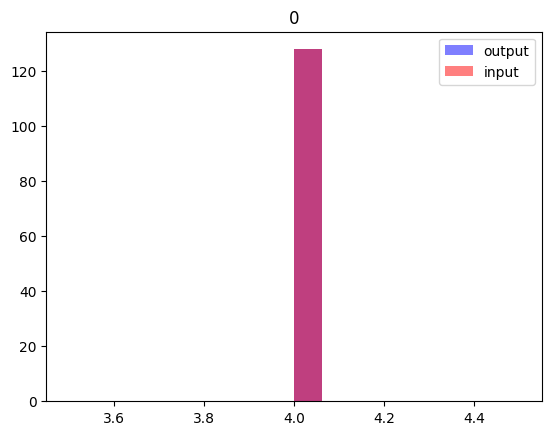

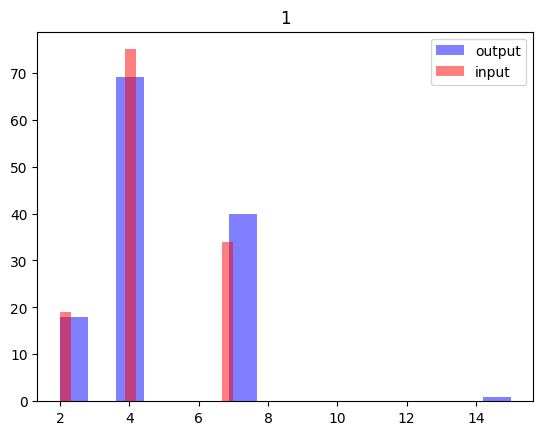

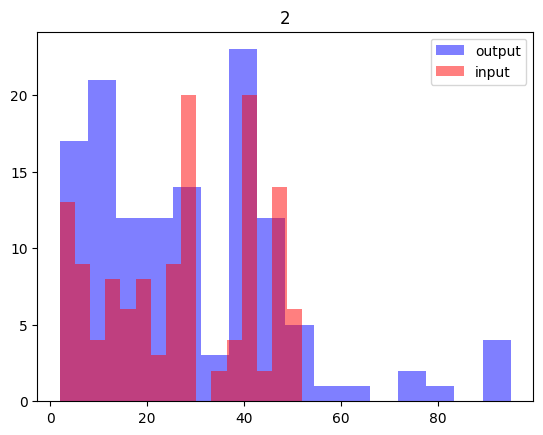

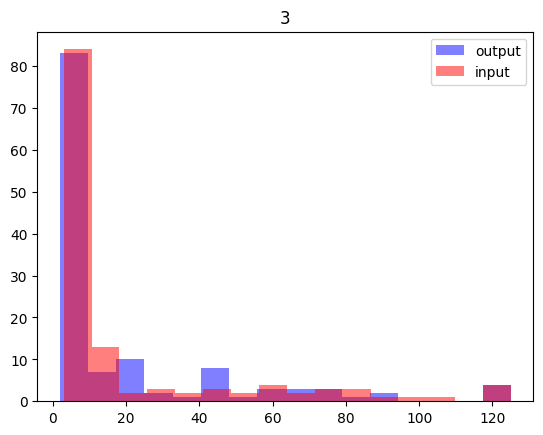

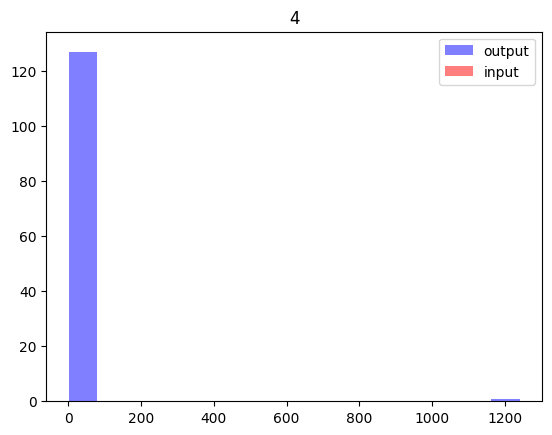

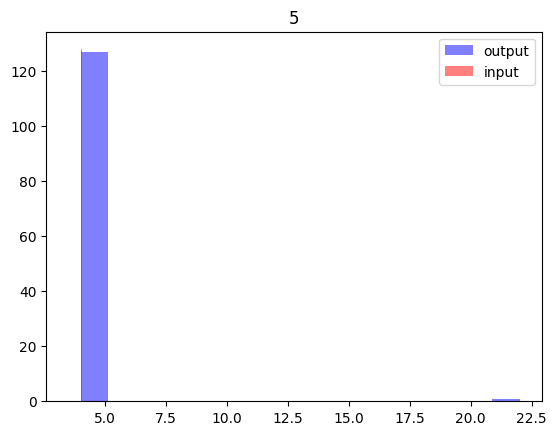

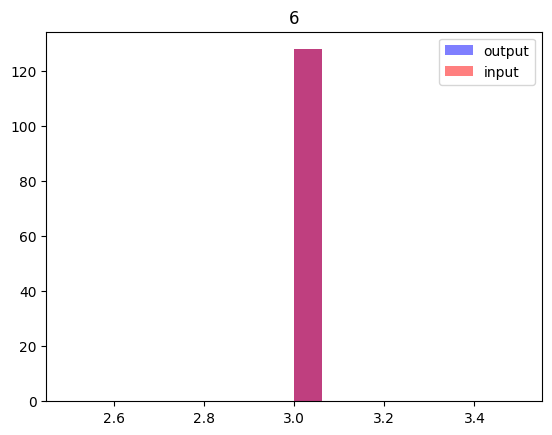

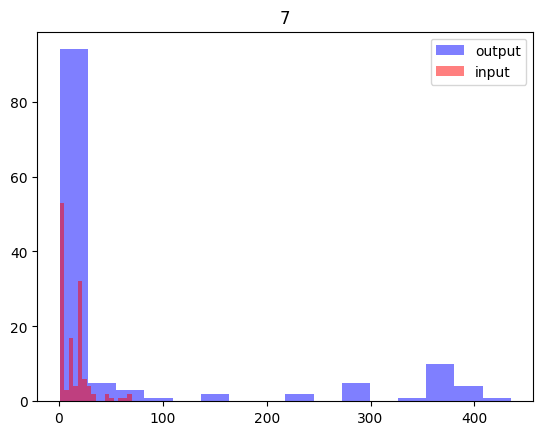

In [360]:
import matplotlib.pyplot as plt

for i in range(len(vocab_sizes)):
    plt.title(i)
    plt.hist(output_np[:, i], color='blue', alpha=.5, bins=16, label='output')
    plt.hist(input_tensor[0][:, i], color='red', alpha=.5, bins=16, label='input')
    plt.legend()
    plt.show()

In [361]:
from midi_functions import decode_events,quick_listen_to_midi, MidiTokenizer

In [362]:
tokenizer.detokenize(input_tensor[0].numpy().astype(int))[:50]

array([['note_on', '3', '62', '96', '-1', '-1', '-1', '1'],
       ['note_on', '3', '62', '0', '-1', '-1', '-1', '3'],
       ['note_on', '3', '63', '92', '-1', '-1', '-1', '0'],
       ['note_on', '1', '38', '104', '-1', '-1', '-1', '13'],
       ['note_on', '9', '37', '100', '-1', '-1', '-1', '0'],
       ['note_on', '9', '51', '127', '-1', '-1', '-1', '0'],
       ['note_on', '9', '44', '127', '-1', '-1', '-1', '0'],
       ['note_on', '1', '40', '0', '-1', '-1', '-1', '0'],
       ['note_on', '3', '67', '17', '-1', '-1', '-1', '0'],
       ['note_on', '3', '67', '0', '-1', '-1', '-1', '1'],
       ['note_on', '3', '59', '0', '-1', '-1', '-1', '4'],
       ['note_on', '9', '37', '0', '-1', '-1', '-1', '1'],
       ['note_on', '9', '44', '0', '-1', '-1', '-1', '0'],
       ['note_on', '9', '51', '0', '-1', '-1', '-1', '0'],
       ['note_on', '3', '54', '0', '-1', '-1', '-1', '2'],
       ['note_on', '3', '63', '0', '-1', '-1', '-1', '1'],
       ['note_on', '3', '62', '56', '-1', '-

In [363]:

test_folder = 'test_output'
output_file = test_folder + 'model_input.mid'

input_midi = decode_midi_properties(tokenizer.detokenize(input_tensor[0].numpy().astype(int)))
input_midi.save(output_file)

In [372]:
from IPython.display import Audio

# quick_listen_to_midi(output_file, 'soundfonts/donkey_kong_country_soundfont_collection/Donkey Kong Country 2012.sf2', test_folder )

In [365]:
tokenizer.tokenizers[0].vocab

{'control_change': '1',
 'pitchwheel': '2',
 'program_change': '3',
 'note_on': '4',
 'note_off': '5',
 'aftertouch': '6',
 'polytouch': '7'}

In [368]:
output_np[:, -1] = input_tensor[0].numpy().astype(int)[:, -1]

In [369]:
output_file = test_folder + 'model_output.mid'
output_midi = decode_midi_properties(tokenizer.detokenize(output_np))
output_midi.save(output_file)

In [373]:
# quick_listen_to_midi(output_file, 'soundfonts/donkey_kong_country_soundfont_collection/Donkey Kong Country 2012.sf2', test_folder )